In [1]:
import pandas as pd
import numpy as np
#import scipy as sp

import pymc as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
db_mon = pd.read_csv('data/mon_clean.csv')
db_med = pd.read_csv('data/med_clean.csv')

db_mon_online = pd.read_csv('data_online/mon_clean.csv')
db_med_online = pd.read_csv('data_online/med_clean.csv')

print('Participants in-person: ', len(db_mon['sub'].unique()), '\nparticipants online: ', len(db_mon_online['sub'].unique()))

Participants in-person:  66 
participants online:  332


In [3]:
# Assign a unique serial number for each participant.
db_mon['subn'] = db_mon['sub'].rank(method='dense').astype(int) - 1
db_mon_online['subn'] = db_mon_online['sub'].rank(method='dense').astype(int) - 1


# Count the number of unique subjects in the 'db_mon' dataset.
n_subs = db_mon['subn'].unique().shape[0]
n_subs_online = db_mon_online['subn'].unique().shape[0]

# Create a list of subject indices for all rows in the 'db_mon' dataset.
sub_idx = db_mon.subn.tolist()
sub_idx_online = db_mon_online.subn.tolist()

# Assign a unique serial number for each participant. This will be useful for indexing operations.
db_med['subn'] = db_med['sub'].rank(method='dense').astype(int) - 1
db_med_online['subn'] = db_med_online['sub'].rank(method='dense').astype(int) - 1


# Count the number of unique subjects in the 'db_med' dataset.
n_subs_med = db_med['subn'].unique().shape[0]
n_subs_med_online = db_med_online['subn'].unique().shape[0]

# Create a list of subject indices for all rows in the 'db_med' dataset.
sub_idx_med = db_med.subn.tolist()
sub_idx_med_online = db_med_online.subn.tolist()

In [4]:
def straw_man(df, n_subs, idx):
    """
    A simple model (straw man) that tries to estimate the influence of value, risk, and ambiguity 
    on the choice made by subjects in a gambling scenario.

    Parameters:
    - df: DataFrame containing data on choice, value, risk, and ambiguity for each trial
    - n_subs: Number of subjects in the study
    - idx: Subject index for each trial (used for hierarchical modeling)

    Returns:
    - trace: Samples from the posterior distribution
    """
    
    with pm.Model() as simple:  # Define a new PyMC3 model
    
        # Define hyperpriors for the group-level parameter (γ)
        gMu = pm.Normal('gMu',  0, 1) # Mean of the normal distribution
        gSig = pm.Gamma('gSig', 2, 1) # Standard deviation (Gamma distribution provides only positive values)

        # Define the subject-specific risk preference (γ) using a lognormal distribution
        γ = pm.Lognormal('γ', gMu, gSig, shape = n_subs)

        # Compute expected value of the lottery outcome
        val  = df['value'].values                                # Values from the 'value' column in the DataFrame
        prob = df['risk'].values - (df['ambiguity'].values / 2)  # Probability calculation adjusted by ambiguity

        svLotto = val * prob # Subjective value of the lottery
        svRef   = 1          # Subjective value of a reference (assumed to be 1)
        
        # Define the linear predictor (p) and compute the expected probability (mu) using the inverse logit function
        p  = (svLotto - svRef) / γ[idx]
        mu =  pm.invlogit(p)                     # The invlogit function transforms values to the (0,1) interval

        # Define the likelihood of the observed data. A binomial likelihood is chosen because the outcome is binary (choice is 0 or 1)
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        trace = pm.sample(idata_kwargs={'log_likelihood':True})
        
    return(trace)

In [5]:
def Utility(df, n_subs, idx):
    """
    Estimate the utility function of the subjects using a model that accounts for both the value of an outcome 
    and the probability of its occurrence.

    Parameters:
    - df: DataFrame containing data on choice, value levels, risk, and ambiguity for each trial.
    - n_subs: Number of subjects in the dataset.
    - idx: Subject index for each trial (used for modeling individual variations).

    Returns:
    - trace: Samples from the posterior distribution.
    """
    
    # Define the probabilistic model for utility function
    with pm.Model() as Utility:
        
        # Hyperpriors define group-level distributions for subject-specific parameters.
        alpha_a = pm.TruncatedNormal('alpha_a', 4, 1, lower = 0)  # Shape parameter for risk attitude
        alpha_b = pm.TruncatedNormal('alpha_b', 7, 3, lower = 0)  # Rate parameter for risk attitude
        bMu     = pm.Normal('bMu',   .65, 1)  # Group-level mean for ambiguity modulation
        bSig    = pm.Gamma('bSig',     4, 1)  # Group-level standard deviation for ambiguity modulation

        # Individual subject priors.
        alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)                        # Subject-specific utility curvature
        α     = pm.Deterministic('α', alpha * 2)                                               # Double the value of alpha for further computations
        β     = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs) # Ambiguity modulation
        γ     = pm.LogNormal('γ', 0, .25, shape = n_subs)                                   # Inverse temperature parameter

        # Calculate expected value of outcome using a power function.
        value = df['value'].values ** α[idx]  # Subjective value based on curvature parameter
        prob  = df['risk'].values  - (β[idx] * (df['ambiguity'].values/2))  # Probability of outcome considering ambiguity

        # Calculate subjective value (SV) of the lottery for each trial
        svLotto = value * prob
        svRef   = 5 ** α[idx]  # Reference value

        # Convert SV into a probability of choosing the lottery using the inverse logit function.
        p  = (svLotto - svRef) / γ[idx]
        mu = pm.invlogit(p)

        # Define likelihood of observations using a Binomial distribution, as choice is binary.
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        trace = pm.sample(idata_kwargs={'log_likelihood':True})
           
    return(trace)

In [6]:
def Utility_th(df, n_subs, idx):
    """
    Estimate the utility function of the subjects using a model that accounts for both the value of an outcome 
    and the probability of its occurrence, with a modified choice function incorporating tremble hand effect (γ).

    Parameters:
    - df: DataFrame containing data on choice, value levels, risk, and ambiguity for each trial.
    - n_subs: Number of subjects in the dataset.
    - idx: Subject index for each trial (used for modeling individual variations).

    Returns:
    - trace: Samples from the posterior distribution.
    """
    
    # Define the probabilistic model for the utility function
    with pm.Model() as trembel_hand:
        
        # Hyperpriors: Define group-level distributions for subject-specific parameters.
        alpha_a = pm.TruncatedNormal('alpha_a', 4, 1, lower = 0)  # Shape parameter for utility curvature
        alpha_b = pm.TruncatedNormal('alpha_b', 7, 3, lower = 0)  # Rate parameter for utility curvature

        g_a = pm.TruncatedNormal('g_a', 2, 1, lower = 1)  # Shape parameter for tremble hand effect
        g_b = pm.TruncatedNormal('g_b', 2, 1, lower = 1)  # Rate parameter for tremble hand effect

        bMu  = pm.Normal('bMu', .65, .5)  # Mean for ambiguity modulation
        bSig = pm.Gamma('bSig', 2, 1)     # Standard deviation for ambiguity modulation

        # Individual subject priors.
        alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)  # Subject-specific utility curvature
        α = pm.Deterministic('α', alpha * 2)  # Double the value of alpha for further computations
        β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)  # Ambiguity modulation
        γ = pm.Beta('γ', g_a, g_b, shape = n_subs)  # Tremble hand effect (probability of random choice)

        # Calculate expected value of outcome using a power function.
        value = df['value'].values ** α[idx]
        prob  = df['risk'].values - (β[idx] * (df['ambiguity'].values/2))

        svLotto = value * prob
        svRef   = 5 ** α[idx]
        
        # Convert SV into a modified probability of choosing the lottery using the inverse logit function 
        # and the tremble hand effect.
        p = (1/(1+np.exp(-(svLotto - svRef)))) * (1-γ[idx]) + γ[idx] * .5
        
        # Define likelihood of observations using a Binomial distribution, as choice is binary.
        choice = pm.Binomial('choice', 1, p, observed=df['choice'])

        trace = pm.sample(idata_kwargs={'log_likelihood':True})
        
    return(trace)

In [7]:
def estamte_values_ordinal(df, n_subs, idx):
    """
    Estimate the value of different reward levels using ordinal constraints and a common hyperprior for each level. 
    The model ensures that the levels are positive (ordinal constraints).

    Parameters:
    - df: DataFrame with trial-specific details, such as choices, value levels, risk, and ambiguity levels.
    - n_sub: Total number of subjects in the dataset.
    - idx: A list indicating the subject ID for each observation/trial.

    Returns:
    - trace: Samples from the posterior distribution of the model.
    """
    
    with pm.Model() as estimate:

        # Hyperparameters for group-level distributions
        bMu  = pm.Normal('bMu', .65, 1)     # Mean for ambiguity effect distribution
        bSig = pm.Gamma('bSig', 2, 1)       # SD for ambiguity effect distribution

        # Hyperparameters for group-level subjective value levels
        l1Mu = pm.TruncatedNormal('l1Mu', 4, 2, lower=0)  # Mean for value of level 1
        l2Mu = pm.TruncatedNormal('l2Mu', 4, 2, lower=0)  # ... level 2
        l3Mu = pm.TruncatedNormal('l3Mu', 4, 2, lower=0)  # ... level 3
        l4Mu = pm.TruncatedNormal('l4Mu', 4, 2, lower=0)  # ... level 4
        
        l1sd = pm.Gamma('l1sd', 3, 1)  # SD for value of level 1
        l2sd = pm.Gamma('l2sd', 3, 1)  # ... level 2
        l3sd = pm.Gamma('l3sd', 3, 1)  # ... level 3
        l4sd = pm.Gamma('l4sd', 3, 1)  # ... level 4
        
        # Subject-specific priors 
        β = pm.Normal('β',    bMu, bSig, shape = n_subs)   # Modulation of ambiguity effect
        γ = pm.Lognormal('γ', 0, 0.25, shape = n_subs)   # Inverse temperature, impacting choice stochasticity

        # Priors for subjective values of the different reward levels for each subject.
        level1 = pm.TruncatedNormal('level1', l1Mu, l1sd, lower = 0, shape = n_subs)
        level2 = pm.TruncatedNormal('level2', l2Mu, l2sd, lower = 0, shape = n_subs)
        level3 = pm.TruncatedNormal('level3', l3Mu, l3sd, lower = 0, shape = n_subs)
        level4 = pm.TruncatedNormal('level4', l4Mu, l4sd, lower = 0, shape = n_subs)

        # Calculate the total expected value for each trial by combining values from different levels
        val = (df['l1'].values * level1[idx] + 
               df['l2'].values * level2[idx] + 
               df['l3'].values * level3[idx] + 
               df['l4'].values * level4[idx]) 

        # Calculate adjusted probability by considering both risk and ambiguity levels modulated by β
        prob = (df['risk'].values) - (β[idx] * (df['ambiguity'].values/2))  

        # Compute the subjective value of the lottery option
        svLotto = val * prob
        svRef   = level1[idx]  # The subjective value of the reference option

        # Transform the SV difference between lottery and reference into a choice probability using the logistic function
        p  = (svLotto - svRef) / γ[idx]
        mu = pm.invlogit(p)

        # Likelihood of the observed choices given the computed probabilities
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        trace = pm.sample(idata_kwargs={'log_likelihood':True})
        
    return trace

In [8]:
mon_simple        = straw_man(             db_mon, n_subs, sub_idx)
mon_utility       = Utility(               db_mon, n_subs, sub_idx)
mon_trmbling_hand = Utility_th(            db_mon, n_subs, sub_idx)
mon_estimated     = estamte_values_ordinal(db_mon, n_subs, sub_idx)

med_simple    = straw_man(             db_med, n_subs_med, sub_idx_med)
med_estimated = estamte_values_ordinal(db_med, n_subs_med, sub_idx_med)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_a, alpha_b, bMu, bSig, alpha, β, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_a, alpha_b, g_a, g_b, bMu, bSig, alpha, β, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 121 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bMu, bSig, l1Mu, l2Mu, l3Mu, l4Mu, l1sd, l2sd, l3sd, l4sd, β, γ, level1, level2, level3, level4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 150 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bMu, bSig, l1Mu, l2Mu, l3Mu, l4Mu, l1sd, l2sd, l3sd, l4sd, β, γ, level1, level2, level3, level4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 166 seconds.


In [9]:
mon_simple_online        = straw_man(db_mon_online, n_subs_online, sub_idx_online)
mon_utility_online       = Utility(db_mon_online, n_subs_online, sub_idx_online)
mon_trmbling_hand_online = Utility_th(db_mon_online, n_subs_online, sub_idx_online)
mon_estimated_online     = estamte_values_ordinal(db_mon_online, n_subs_online, sub_idx_online)

med_simple_online    = straw_man(db_med_online, n_subs_med_online, sub_idx_med_online)
med_estimated_online = estamte_values_ordinal(db_med_online, n_subs_med_online, sub_idx_med_online)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 137 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_a, alpha_b, bMu, bSig, alpha, β, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 292 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_a, alpha_b, g_a, g_b, bMu, bSig, alpha, β, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 290 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bMu, bSig, l1Mu, l2Mu, l3Mu, l4Mu, l1sd, l2sd, l3sd, l4sd, β, γ, level1, level2, level3, level4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 547 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bMu, bSig, l1Mu, l2Mu, l3Mu, l4Mu, l1sd, l2sd, l3sd, l4sd, β, γ, level1, level2, level3, level4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 482 seconds.


In [10]:
compare_dict = {'simple model':    mon_simple, 
                'Classic Utility': mon_utility,
                'Trembling-hand':  mon_trmbling_hand, 
                'estimated':       mon_estimated,

}

comp = az.compare(compare_dict)
comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
estimated,0,-1561.980123,224.066731,0.000000,9.561933e-01,45.542753,0.000000,True,log
Classic Utility,1,-1910.780188,143.192081,348.800065,4.593331e-09,42.371385,24.342808,True,log
Trembling-hand,2,-1976.544811,137.502574,414.564688,4.011167e-02,36.612328,29.590388,True,log
simple model,3,-3457.328407,34.353240,1895.348284,3.695063e-03,22.046612,43.632311,False,log


In [11]:
compare_dict = {'simple model':    mon_simple_online, 
                'Classic Utility': mon_utility_online,
                'Trembling-hand':  mon_trmbling_hand_online, 
                'estimated':       mon_estimated_online,

}

comp = az.compare(compare_dict)
comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
estimated,0,-3788.272747,822.320579,0.000000,9.963300e-01,68.959715,0.000000,True,log
Classic Utility,1,-5208.958772,449.435936,1420.686025,1.426481e-10,57.575079,41.423700,True,log
Trembling-hand,2,-5801.635740,403.553262,2013.362994,1.287265e-10,54.205022,46.719916,True,log
simple model,3,-11034.226814,95.993132,7245.954067,3.670041e-03,17.671602,69.189481,True,log


In [12]:
compare_dict = {'Simple model': med_simple, 
                'Estimated':    med_estimated
}

comp = az.compare(compare_dict)
comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Estimated,0,-1412.748487,211.394060,0.000000,0.986974,45.152534,0.000000,True,log
Simple model,1,-2929.780621,46.376745,1517.032134,0.013026,32.087920,42.356802,True,log


In [13]:
compare_dict = {'Simple model': med_simple_online, 
                'Estimated':    med_estimated_online
}

comp = az.compare(compare_dict)
comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Estimated,0,-4100.441936,785.314616,0.000000,0.990777,72.764777,0.000000,True,log
Simple model,1,-9514.343003,181.018543,5413.901067,0.009223,44.785585,73.717355,True,log


In [14]:
print("In-person: ")

print("level 1 (med): mean:", az.summary(med_estimated, var_names=['level1'])['mean'].mean(), "SD: ", az.summary(med_estimated, var_names=['level1'])['sd'].mean())
print("level 2 (med): mean:", az.summary(med_estimated, var_names=['level2'])['mean'].mean(), "SD: ", az.summary(med_estimated, var_names=['level2'])['sd'].mean())
print("level 3 (med): mean:", az.summary(med_estimated, var_names=['level3'])['mean'].mean(), "SD: ", az.summary(med_estimated, var_names=['level3'])['sd'].mean())
print("level 4 (med): mean:", az.summary(med_estimated, var_names=['level4'])['mean'].mean(), "SD: ", az.summary(med_estimated, var_names=['level4'])['sd'].mean())

print("level 1 (mon): mean:", az.summary(mon_estimated, var_names=['level1'])['mean'].mean(), "SD: ", az.summary(mon_estimated, var_names=['level1'])['sd'].mean())
print("level 2 (mon): mean:", az.summary(mon_estimated, var_names=['level2'])['mean'].mean(), "SD: ", az.summary(mon_estimated, var_names=['level2'])['sd'].mean())
print("level 3 (mon): mean:", az.summary(mon_estimated, var_names=['level3'])['mean'].mean(), "SD: ", az.summary(mon_estimated, var_names=['level3'])['sd'].mean())
print("level 4 (mon): mean:", az.summary(mon_estimated, var_names=['level4'])['mean'].mean(), "SD: ", az.summary(mon_estimated, var_names=['level4'])['sd'].mean())

In-person: 
level 1 (med): mean: 6.922166666666667 SD:  1.7833636363636363
level 2 (med): mean: 8.97019696969697 SD:  2.5907272727272725
level 3 (med): mean: 6.997530303030302 SD:  2.8700757575757576
level 4 (med): mean: 4.214984848484849 SD:  2.427439393939394
level 1 (mon): mean: 7.1884696969696975 SD:  1.5962121212121212
level 2 (mon): mean: 4.124106060606061 SD:  1.4626666666666668
level 3 (mon): mean: 6.20810606060606 SD:  2.166030303030303
level 4 (mon): mean: 8.752106060606058 SD:  3.396287878787879


In [16]:
print("Online: ")

print("level 1 (med): mean:", az.summary(med_estimated_online, var_names=['level1'])['mean'].mean(), "SD: ", az.summary(med_estimated_online, var_names=['level1'])['sd'].mean())
print("level 2 (med): mean:", az.summary(med_estimated_online, var_names=['level2'])['mean'].mean(), "SD: ", az.summary(med_estimated_online, var_names=['level2'])['sd'].mean())
print("level 3 (med): mean:", az.summary(med_estimated_online, var_names=['level3'])['mean'].mean(), "SD: ", az.summary(med_estimated_online, var_names=['level3'])['sd'].mean())
print("level 4 (med): mean:", az.summary(med_estimated_online, var_names=['level4'])['mean'].mean(), "SD: ", az.summary(med_estimated_online, var_names=['level4'])['sd'].mean())

print("level 1 (mon): mean:", az.summary(mon_estimated_online, var_names=['level1'])['mean'].mean(), "SD: ", az.summary(mon_estimated_online, var_names=['level1'])['sd'].mean())
print("level 2 (mon): mean:", az.summary(mon_estimated_online, var_names=['level2'])['mean'].mean(), "SD: ", az.summary(mon_estimated_online, var_names=['level2'])['sd'].mean())
print("level 3 (mon): mean:", az.summary(mon_estimated_online, var_names=['level3'])['mean'].mean(), "SD: ", az.summary(mon_estimated_online, var_names=['level3'])['sd'].mean())
print("level 4 (mon): mean:", az.summary(mon_estimated_online, var_names=['level4'])['mean'].mean(), "SD: ", az.summary(mon_estimated_online, var_names=['level4'])['sd'].mean())

Online: 
level 1 (med): mean: 8.629030120481929 SD:  2.534725903614458
level 2 (med): mean: 12.632602409638553 SD:  4.239542168674699
level 3 (med): mean: 4.662340361445783 SD:  2.5555301204819276
level 4 (med): mean: 2.366677710843373 SD:  1.599737951807229
level 1 (mon): mean: 10.908753012048193 SD:  2.7209668674698797
level 2 (mon): mean: 4.129743975903614 SD:  1.8442771084337348
level 3 (mon): mean: 5.041 SD:  2.3550933734939763
level 4 (mon): mean: 3.926900602409638 SD:  2.180298192771084


In [17]:
# Similar process for the monetery dataset
df = db_mon[['sub','age', 'gender']].sort_values('sub').drop_duplicates().reset_index(drop=True)
df['age'] = df.age.astype('int')

# extract parameters from the model
level1 = az.summary(mon_estimated, var_names=['level1'])[['mean']]
level2 = az.summary(mon_estimated, var_names=['level2'])[['mean']]
level3 = az.summary(mon_estimated, var_names=['level3'])[['mean']]
level4 = az.summary(mon_estimated, var_names=['level4'])[['mean']]
beta   = az.summary(mon_estimated, var_names=['β']     )[['mean']]

# change column names
level1 = level1.rename(columns={'mean': "level1_mon"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_mon"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_mon"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_mon"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "amb_est_mon"}  ).reset_index(drop=True)

# combine to a single dataframe
df = df.merge(level1, left_index=True, right_index=True)
df = df.merge(level2, left_index=True, right_index=True)
df = df.merge(level3, left_index=True, right_index=True)
df = df.merge(level4, left_index=True, right_index=True)
df = df.merge(beta,   left_index=True, right_index=True)

In [18]:
# extract parameters from the model
level1 = az.summary(med_estimated, var_names=['level1'])[['mean']]
level2 = az.summary(med_estimated, var_names=['level2'])[['mean']]
level3 = az.summary(med_estimated, var_names=['level3'])[['mean']]
level4 = az.summary(med_estimated, var_names=['level4'])[['mean']]
beta   = az.summary(med_estimated, var_names=['β']     )[['mean']]

# change column names
level1 = level1.rename(columns={'mean': "level1_med"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_med"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_med"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_med"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "amb_est_med"}  ).reset_index(drop=True)

# combine to a single dataframe
df = df.merge(level1, left_index=True, right_index=True)
df = df.merge(level2, left_index=True, right_index=True)
df = df.merge(level3, left_index=True, right_index=True)
df = df.merge(level4, left_index=True, right_index=True)
df = df.merge(beta,   left_index=True, right_index=True)

In [20]:
# Similar process for the monetery dataset
df_online = db_mon_online[['sub','age', 'gender']].sort_values('sub').drop_duplicates().reset_index(drop=True)
df_online['age'] = df.age.astype('int')

# extract parameters from the model
level1 = az.summary(mon_estimated_online, var_names=['level1'])[['mean']]
level2 = az.summary(mon_estimated_online, var_names=['level2'])[['mean']]
level3 = az.summary(mon_estimated_online, var_names=['level3'])[['mean']]
level4 = az.summary(mon_estimated_online, var_names=['level4'])[['mean']]
beta   = az.summary(mon_estimated_online, var_names=['β']     )[['mean']]

# change column names
level1 = level1.rename(columns={'mean': "level1_mon"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_mon"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_mon"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_mon"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "amb_est_mon"}  ).reset_index(drop=True)

# combine to a single dataframe
df_online = df_online.merge(level1, left_index=True, right_index=True)
df_online = df_online.merge(level2, left_index=True, right_index=True)
df_online = df_online.merge(level3, left_index=True, right_index=True)
df_online = df_online.merge(level4, left_index=True, right_index=True)
df_online = df_online.merge(beta,   left_index=True, right_index=True)

In [21]:
# extract parameters from the model
level1 = az.summary(med_estimated_online, var_names=['level1'])[['mean']]
level2 = az.summary(med_estimated_online, var_names=['level2'])[['mean']]
level3 = az.summary(med_estimated_online, var_names=['level3'])[['mean']]
level4 = az.summary(med_estimated_online, var_names=['level4'])[['mean']]
beta   = az.summary(med_estimated_online, var_names=['β']     )[['mean']]

# change column names
level1 = level1.rename(columns={'mean': "level1_med"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_med"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_med"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_med"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "amb_est_med"}  ).reset_index(drop=True)

# combine to a single dataframe
df_online = df_online.merge(level1, left_index=True, right_index=True)
df_online = df_online.merge(level2, left_index=True, right_index=True)
df_online = df_online.merge(level3, left_index=True, right_index=True)
df_online = df_online.merge(level4, left_index=True, right_index=True)
df_online = df_online.merge(beta,   left_index=True, right_index=True)

In [22]:
def corr(x, y):
    with pm.Model() as RR:

        a = pm.Normal('intercept', 0, 1)
        b = pm.Normal('slope', 0, 1)
        eps = pm.Exponential('eps', 1)
        y_hat = a + b*x

        nu = pm.InverseGamma("nu", alpha=3, beta=1)

        likelihood = pm.StudentT("likelihood", mu=y_hat, sigma=eps, nu=nu, observed=y)

        trace_robust = pm.sample()
        
    return(trace_robust)

In [23]:
est   = corr(df.amb_est_mon, df.amb_est_med)
est_o = corr(df_online.amb_est_mon, df_online.amb_est_med)


es   = az.summary(est, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
es_o = az.summary(est_o, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [24]:
# Reshape the dataframe 'df' from wide to long format using the melt function.

# calculate the SV of each level
df['level1m'] = df['level1_mon']
df['level2m'] = df['level1m'] + df['level2_mon']
df['level3m'] = df['level2m'] + df['level3_mon']
df['level4m'] = df['level3m'] + df['level4_mon']

df_long_mon = df.melt(id_vars='sub',
                      value_vars=['level1m', 'level2m', 'level3m', 'level4m'], 
                      var_name='level')


level_mapping = {
    'level1m': 5,
    'level2m': 8,
    'level3m': 12,
    'level4m': 25
}


# Apply the mapping to the 'level' column in 'df_long_med' and create a new column 'levelName' that holds the descriptive names.
df_long_mon['levelName'] = df_long_mon['level'].map(level_mapping)

df['level1md'] = df['level1_med']
df['level2md'] = df['level1md'] + df['level2_med']
df['level3md'] = df['level2md'] + df['level3_med']
df['level4md'] = df['level3md'] + df['level4_med']

# Reshape the dataframe 'df' from wide to long format using the melt function.
df_long_med = df.melt(id_vars='sub',
                      value_vars=['level1md', 'level2md', 'level3md', 'level4md'], 
                      var_name='level')


# Create a mapping dictionary for levels. This provides a more descriptive name for each 'level' in 'df_long_med'.
level_mapping = {
    'level1md': 'Slight',
    'level2md': 'Moderate',
    'level3md': 'Major',
    'level4md': 'Complete recovery'
}

# Apply the mapping to the 'level' column in 'df_long_med' and create a new column 'levelName' that holds the descriptive names.
df_long_med['levelName'] = df_long_med['level'].map(level_mapping)

In [39]:
# Reshape the dataframe 'df' from wide to long format using the melt function.

# calculate the SV of each level
df_online['level1m'] = df_online['level1_mon']
df_online['level2m'] = df_online['level1m'] + df_online['level2_mon']
df_online['level3m'] = df_online['level2m'] + df_online['level3_mon']
df_online['level4m'] = df_online['level3m'] + df_online['level4_mon']

df_long_mon_online = df_online.melt(id_vars='sub',
                                    value_vars=['level1m', 'level2m', 'level3m', 'level4m'],
                                    var_name='level')


level_mapping = {
    'level1m': 5,
    'level2m': 8,
    'level3m': 12,
    'level4m': 25
}


# Apply the mapping to the 'level' column in 'df_long_med' and create a new column 'levelName' that holds the descriptive names.
df_long_mon_online['levelName'] = df_long_mon_online['level'].map(level_mapping)

df_online['level1md'] = df_online['level1_med']
df_online['level2md'] = df_online['level1md'] + df_online['level2_med']
df_online['level3md'] = df_online['level2md'] + df_online['level3_med']
df_online['level4md'] = df_online['level3md'] + df_online['level4_med']

# Reshape the dataframe 'df' from wide to long format using the melt function.
df_long_med_online = df.melt(id_vars='sub',
                             value_vars=['level1md', 'level2md', 'level3md', 'level4md'], 
                             var_name='level')


# Create a mapping dictionary for levels. This provides a more descriptive name for each 'level' in 'df_long_med'.
level_mapping = {
    'level1md': 'Slight',
    'level2md': 'Moderate',
    'level3md': 'Major',
    'level4md': 'Complete recovery'
}

# Apply the mapping to the 'level' column in 'df_long_med' and create a new column 'levelName' that holds the descriptive names.
df_long_med_online['levelName'] = df_long_med_online['level'].map(level_mapping)

In [41]:
df_long_med['subn']  = df_long_med['sub'].rank(method='dense').astype(int) - 1
df_long_mon['subn']  = df_long_mon['sub'].rank(method='dense').astype(int) - 1

df_long_med_online['subn']  = df_long_med_online['sub'].rank(method='dense').astype(int) - 1
df_long_mon_online['subn']  = df_long_mon_online['sub'].rank(method='dense').astype(int) - 1

df_long_mon['levelName'] = df_long_mon['levelName'].astype('str')
df_long_mon_online['levelName'] = df_long_mon_online['levelName'].astype('str')

In [32]:
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [33]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=65)
colors = {}
cmap = plt.get_cmap('tab20', 66)  # Create a colormap with 66 unique colors

for cval in range(0,66):
    colors.update({cval : cmap(norm(cval))})

norm2 = matplotlib.colors.Normalize(vmin=0, vmax=332)
colors2 = {}
cmap2 = plt.get_cmap('tab20', 332)  

for cval2 in range(0,332):
    colors2.update({cval2 : cmap2(norm2(cval2))})

In [34]:
# Function to add the mean as a big black dot
def add_mean_dot(ax, data, x, y):
    means = data.groupby(x)[y].mean().reset_index()
    ax.scatter(means[x], means[y], s=200, color='black', zorder=3)

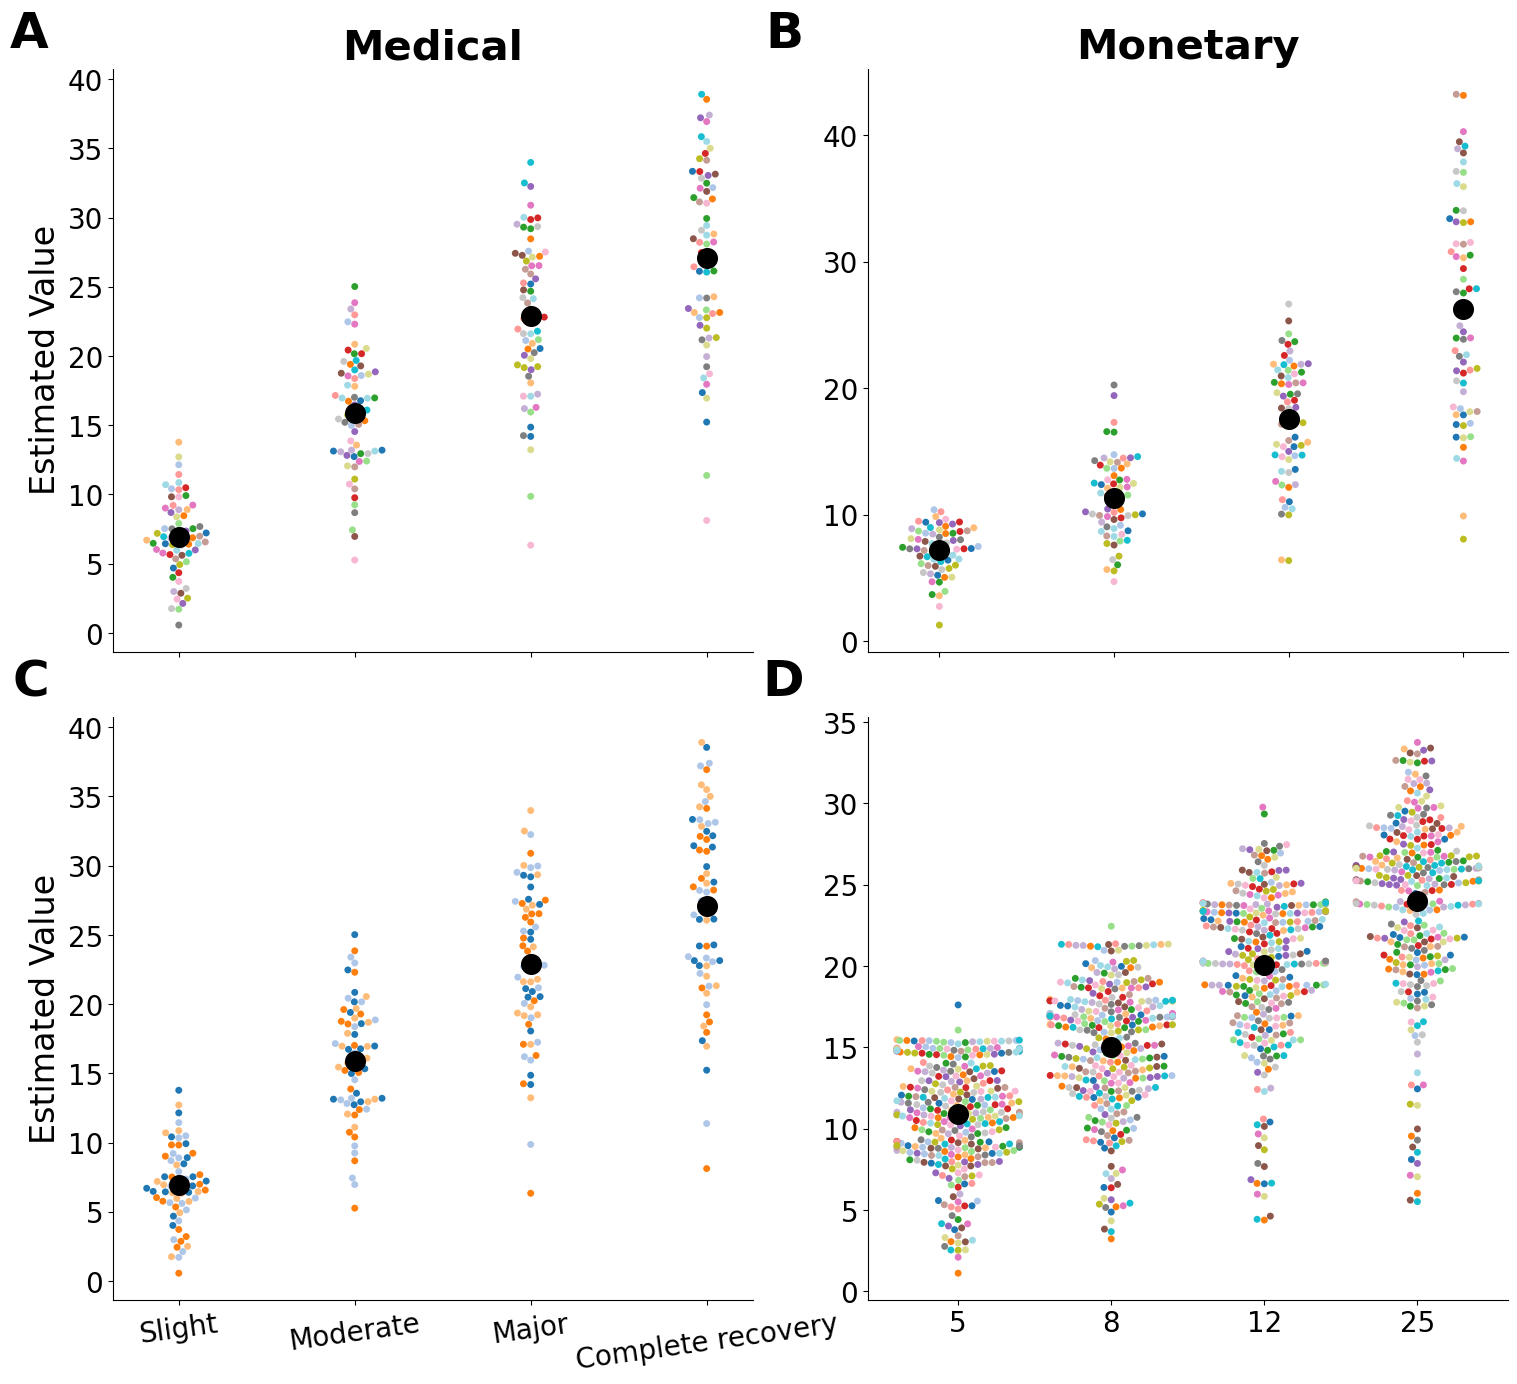

In [42]:
# This will visualize the relationship between different levels and their estimated values for Monetary and Medical contexts.
fig, axes = plt.subplots(2, 2, figsize=(18, 16)) # Initialize a 1x2 subplot layout, with a shared y-axis.


# Plot the estimated value for each level in the 'Medical' context on the second axis.
sns.swarmplot(data=df_long_med, x='levelName', y='value', ax=axes[0,0], hue = 'subn', palette = colors)
sns.swarmplot(data=df_long_med_online, x='levelName', y='value', ax=axes[1,0], hue = 'subn', palette = colors2)

# Plot the estimated value for each level in the 'Monetary' context on the first axis.
sns.swarmplot(data=df_long_mon, x='levelName', y='value', ax=axes[0,1], hue = 'subn', palette = colors)
sns.swarmplot(data=df_long_mon_online, x='levelName', y='value', ax=axes[1,1], hue = 'subn', palette = colors2)


# Set the title for each subplot.
axes[0,0].set_title('Medical', fontweight="bold", size=30)
axes[0,1].set_title('Monetary', fontweight="bold", size=30)

# Set the y-axis label for the first subplot.
axes[0,0].set_ylabel('Estimated Value', fontsize=24.0)
axes[0,1].set_ylabel('', fontsize=24.0)
axes[1,0].set_ylabel('Estimated Value', fontsize=24.0)
axes[1,1].set_ylabel('', fontsize=24.0)

axes[0, 0].set_xticklabels([])
axes[0, 1].set_xticklabels([])

# Add a slight rotation to the x-axis tick labels on the second plot for better visualization.
axes[1,0].tick_params(axis='x', labelrotation=8)

# Add the mean dots to each subplot
add_mean_dot(axes[0, 0], df_long_med, 'levelName', 'value')
add_mean_dot(axes[1, 0], df_long_med_online, 'levelName', 'value')
add_mean_dot(axes[0, 1], df_long_mon, 'levelName', 'value')
add_mean_dot(axes[1, 1], df_long_mon_online, 'levelName', 'value')

# Set the background color for both plots to white for clarity and aesthetic appeal.
for i in range(2):
    for j in range(2):
        axes[i,j].tick_params(axis='both', which='major', labelsize=20)
        axes[i][j].legend_.remove()
        axes[i,j].set_facecolor('White')
        axes[i,j].set_xlabel('', fontsize=24.0)
        for spine in ['right', 'top']:
            axes[i,j].spines[spine].set_color('white')


subplot_labels = ['A', 'B', 'C', 'D']

for ax, label in zip(axes.flat, subplot_labels):
    # Position the text at the top left of each subplot
    # Adjust x and y values to change the position of the label
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=36, fontweight='bold', va='top', ha='right')

# Adjust the layout to ensure that the plots do not overlap and everything fits well.
fig.subplots_adjust(hspace=0.11, wspace=0.18)  # Adjust the values as needed
#fig.tight_layout()

plt.savefig('figure2.png')

In [43]:
es

,mean,hdi_5.5%,hdi_94.5%
slope,0.764,0.635,0.898
intercept,0.075,-0.006,0.156


In [44]:
es_o

,mean,hdi_5.5%,hdi_94.5%
slope,0.368,0.291,0.439
intercept,0.206,0.168,0.240


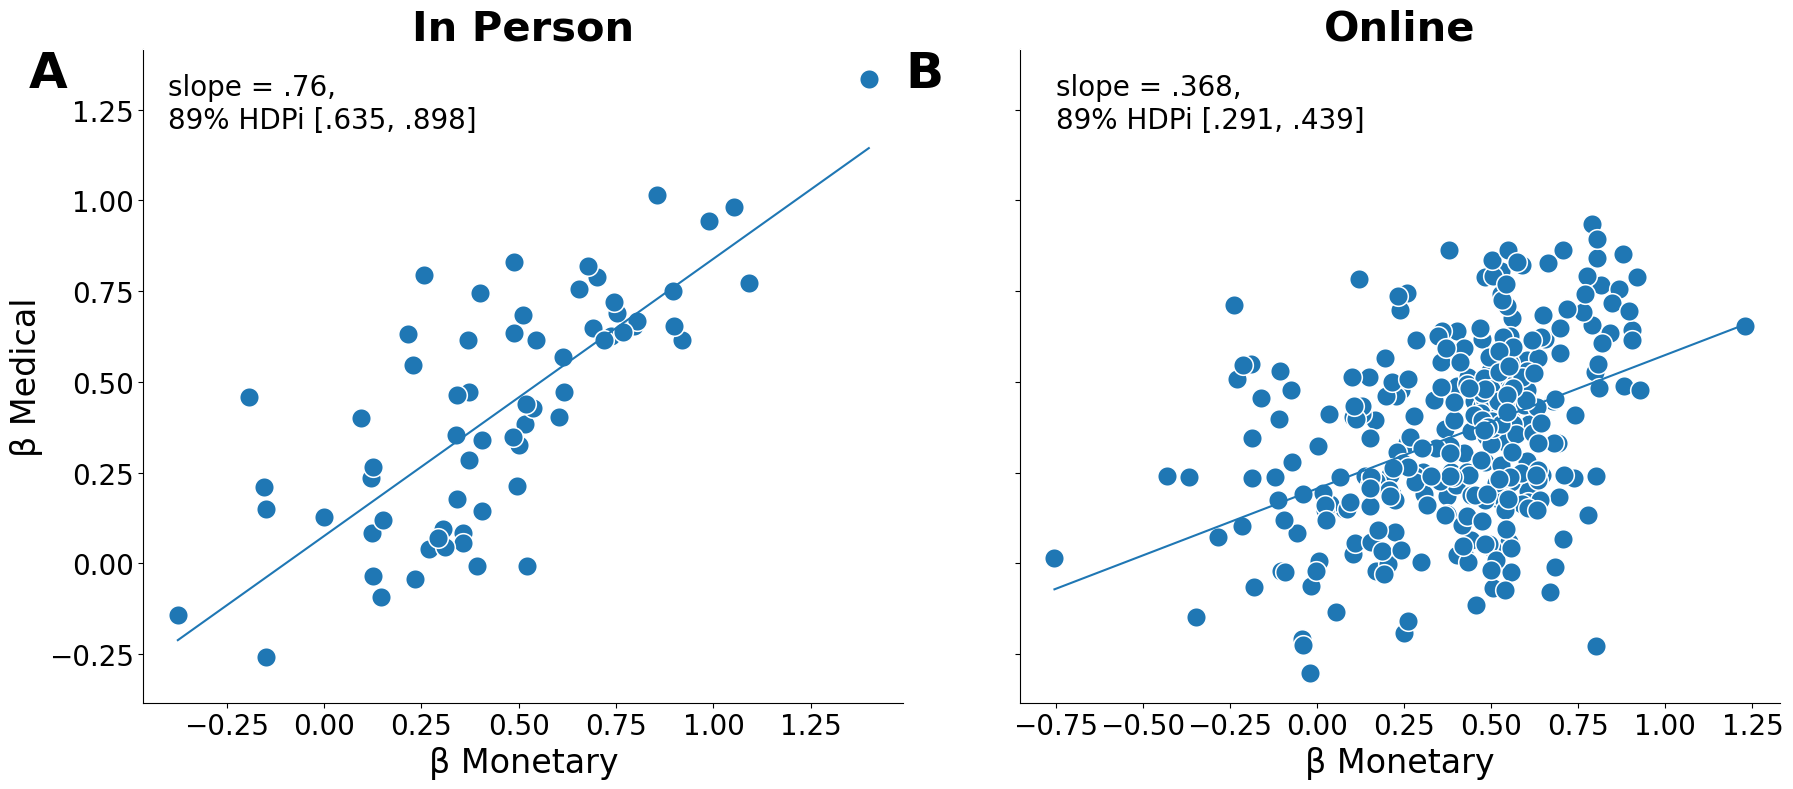

In [49]:
# This will visualize the relationship between different levels and their estimated values for Monetary and Medical contexts.
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True) # Initialize a 1x2 subplot layout, with a shared y-axis.

sns.scatterplot(data = df, x = 'amb_est_mon', y = 'amb_est_med', s = 200, ax=axes[0])
sns.lineplot(x = df.amb_est_mon, 
             y = es['mean']['intercept']+es['mean']['slope']*df.amb_est_mon, 
             ax=axes[0])

sns.scatterplot(data = df_online, x = 'amb_est_mon', y = 'amb_est_med', s = 200, ax=axes[1])
sns.lineplot(x = df_online.amb_est_mon, 
             y = es_o['mean']['intercept']+es_o['mean']['slope']*df_online.amb_est_mon, 
             ax=axes[1])

# Set the title for each subplot.
axes[0].set_title('In Person', fontweight="bold", size=30)
axes[1].set_title('Online', fontweight="bold", size=30)

texts = ['slope = .76,\n89% HDPi [.635, .898]',
         'slope = .368,\n89% HDPi [.291, .439]']
axes[0].set_ylabel('β Medical', fontsize=24.0)

axes[0].text(-.4, 1.2, texts[0], fontsize=20)
axes[1].text(-.75, 1.2, texts[1], fontsize=20)


for i in range(2):
    axes[i].tick_params(axis='both', which='major', labelsize=20)
    
    axes[i].set_xlabel('β Monetary', fontsize=24.0)
    axes[i].set_facecolor('White')

    for spine in ['right', 'top']:
        axes[i].spines[spine].set_color('white')

    
    
subplot_labels = ['A', 'B']

for ax, label in zip(axes.flat, subplot_labels):
    # Position the text at the top left of each subplot
    # Adjust x and y values to change the position of the label
    ax.text(-0.1, 1, label, transform=ax.transAxes, fontsize=36, fontweight='bold', va='top', ha='right')


fig.tight_layout()

plt.savefig('figure3.png')

In [50]:
mon_simple.to_netcdf('data/mon_simple.nc')
mon_utility.to_netcdf('data/mon_utility.nc')
mon_trmbling_hand.to_netcdf('data/mon_trmbling_hand.nc')
mon_estimated.to_netcdf('data/mon_estimated.nc')
med_simple.to_netcdf('data/med_simple.nc')
med_estimated.to_netcdf('data/med_estimated.nc')

mon_simple_online.to_netcdf('data_online/mon_simple.nc')
mon_utility_online.to_netcdf('data_online/mon_utility.nc')
mon_trmbling_hand_online.to_netcdf('data_online/mon_trmbling_hand.nc')
mon_estimated_online.to_netcdf('data_online/mon_estimated.nc')
med_simple_online.to_netcdf('data_online/med_simple.nc')
med_estimated_online.to_netcdf('data_online/med_estimated.nc')

'data_online/med_estimated.nc'